# Notebook de EDA
Este notebook realiza un Exploratory Data Analysis reproducible para el dataset German Credit presente en el repositorio. Contiene secciones de carga, limpieza, análisis de distribuciones, tratamiento de outliers, ingeniería de features y guardado de artefactos.
Ejecuta las celdas en orden.

In [7]:
# Importar librerías
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
#import nbformat
import warnings
warnings.filterwarnings('ignore')

# Opciones de visualización
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)
sns.set(style='whitegrid')

## Sección 1: Carga del dataset y configuración de rutas
Definir rutas relativas y cargar `df` (modificado) y `df_orig` (original de referencia).

In [19]:
# Rutas (ajusta si es necesario)
#RAW_PATH = Path('/Users/fernandoperezescalante/intento4mlops/MLOps') / 'src' / 'data' / 'raw' / 'german_credit_modified.csv'

# Rutas (ajusta si es necesario)
RAW_PATH = Path('..') / 'src' / 'data' / 'raw' / 'german_credit_modified.csv'
ORIG_PATH = Path('..') / 'src' / 'data' / 'original' / 'german_credit_original.csv'
OUT_PATH_EXTRA = Path('..') / 'src' / 'data' / 'raw' / 'extra_rows_identified.csv'
OUT_PATH_CLEAN = Path('..') / 'src' / 'data'/ 'processed' /  'german_credit_clean.csv'

print('RAW_PATH ->', RAW_PATH.resolve())
print('ORIG_PATH ->', ORIG_PATH.resolve())

# Cargar (con try/except para fallos de lectura)
try:
    df = pd.read_csv(RAW_PATH)
    df_orig = pd.read_csv(ORIG_PATH)
    print('Archivos cargados con éxito')
except Exception as e:
    print('Error cargando CSVs:', e)
    raise

RAW_PATH -> /Users/fernandoperezescalante/intento4mlops/MLOps/src/data/raw/german_credit_modified.csv
ORIG_PATH -> /Users/fernandoperezescalante/intento4mlops/MLOps/src/data/original/german_credit_original.csv
Archivos cargados con éxito


## Sección 2: Eliminar columnas extras
Detectamos columnas que no forman parte del dataset y contienen mezcla de valores numéricos y texto y las eliminamos para evitar problemas en pasos posteriores.

In [20]:
# Eliminar columnas extra que no estén en df_orig
extra_cols = [c for c in df.columns if c not in df_orig.columns]
if extra_cols:
    print("Columnas extra detectadas y eliminadas:", extra_cols)
    df = df.drop(columns=extra_cols)


Columnas extra detectadas y eliminadas: ['mixed_type_col']


## Sección 3: Inspección inicial del dataset
Vista rápida de shape, head, info y tipos.

In [21]:
print('df shape:', df.shape)
print('df_orig shape:', df_orig.shape)

print('\nPrimeras filas df:')
display(df.head())
print('\nPrimeras filas df_orig:')
display(df_orig.head())

print('\nInfo df:')
df.info()
print('\nInfo df_orig:')
df_orig.info()

print('\nDtypes df:\n', df.dtypes)
print('\nDtypes df_orig:\n', df_orig.dtypes)

print('\nNulos por columna (df):')
display(df.isna().sum().sort_values(ascending=False).head(30))


df shape: (1020, 21)
df_orig shape: (1000, 21)

Primeras filas df:


,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,wohnzeit,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit
0,1.0,18.0,4.0,2.0,1049.0,1.0,2.0,4.0,2.0,1.0,4.0,2.0,21.0,3.0,1.0,1.0,3.0,2.0,1.0,2.0,1.0
1,1.0,9.0,4.0,0.0,2799.0,1.0,3.0,2.0,3.0,1.0,2.0,1.0,36.0,3.0,1.0,2.0,3.0,1.0,1.0,2.0,1.0
2,2.0,12.0,2.0,9.0,841.0,2.0,4.0,2.0,2.0,1.0,4.0,1.0,23.0,3.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0
3,1.0,12.0,4.0,0.0,2122.0,1.0,3.0,3.0,3.0,1.0,2.0,1.0,39.0,3.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0
4,1.0,12.0,4.0,0.0,2171.0,1.0,3.0,4.0,3.0,NaN,4.0,2.0,38.0,1.0,2.0,2.0,2.0,error,1.0,1.0,1.0



Primeras filas df_orig:


,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,wohnzeit,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit
0,1,18,4,2,1049,1,2,4,2,1,4,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,2,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,4,1,23,3,1,1,2,2,1,2,1
3,1,12,4,0,2122,1,3,3,3,1,2,1,39,3,1,2,2,1,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,4,2,38,1,2,2,2,2,1,1,1



Info df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   laufkont  1005 non-null   object
 1   laufzeit  1010 non-null   object
 2   moral     1003 non-null   object
 3   verw      1004 non-null   object
 4   hoehe     1012 non-null   object
 5   sparkont  1008 non-null   object
 6   beszeit   1003 non-null   object
 7   rate      1011 non-null   object
 8   famges    1013 non-null   object
 9   buerge    1007 non-null   object
 10  wohnzeit  1005 non-null   object
 11  verm      1009 non-null   object
 12  alter     1009 non-null   object
 13  weitkred  1010 non-null   object
 14  wohn      1015 non-null   object
 15  bishkred  1008 non-null   object
 16  beruf     1008 non-null   object
 17  pers      1012 non-null   object
 18  telef     1012 non-null   object
 19  gastarb   1005 non-null   object
 20  kredit    1004 non-null   object
dtypes: o

beszeit     17
moral       17
kredit      16
verw        16
gastarb     15
laufkont    15
wohnzeit    15
buerge      13
sparkont    12
bishkred    12
beruf       12
verm        11
alter       11
laufzeit    10
weitkred    10
rate         9
pers         8
telef        8
hoehe        8
famges       7
wohn         5
dtype: int64

## Sección 3.1: Inspección inicial del dataset
Almacenamiento de Data Original temporalmente 


In [34]:
# Copia del original modificado sin limpiar outliers
df2 = pd.read_csv(RAW_PATH)

# LIMPIEZA BÁSICA PARA df2 (sin outliers)
# 1. Quitar columnas extra
extra_cols2 = [c for c in df2.columns if c not in df_orig.columns]
if extra_cols2:
    df2 = df2.drop(columns=extra_cols2)

# 2. Strip en strings
for col in df2.columns:
    if df2[col].dtype == object:
        df2[col] = df2[col].astype(str).str.strip()

# 3. Reemplazar valores inválidos por NaN

missing_tokens = ["N/A", "NA", "NULL", "null", "?", "unknown", 
                  "error", "invalid", "INVALID", "", "None"]
df2.replace(missing_tokens, np.nan, inplace=True)


# 4. Convertir a numérico
for col in df2.columns:
    df2[col] = pd.to_numeric(df2[col], errors='coerce')

# 5. Rellenar NaNs desde df_orig si coincide forma
if df2.shape == df_orig.shape:
    for col in df2.columns:
        df2[col] = df2[col].fillna(df_orig[col])

# 6. Rellenar NaNs restantes con 0
df2 = df2.fillna(0)

# 7. Intentar cast a int64
try:
    df2 = df2.astype("int64")
except:
    for col in df2.columns:
        try:
            df2[col] = df2[col].astype("int64")
        except:
            pass

## Sección 4: Limpieza básica (nombres de columnas, duplicados)
Normalizar nombres de columnas y eliminar duplicados visibles.

In [22]:
# Normalizar nombres de columnas
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace(' ', '_').str.lower()
df_orig.columns = df_orig.columns.str.strip().str.replace(' ', '_').str.lower()
print('Columnas normalizadas')
display(df.columns)

# Duplicados
dups = df.duplicated().sum()
print(f'Filas duplicadas en df: {dups}')
if dups > 0:
    df = df.drop_duplicates().reset_index(drop=True)
    print('Duplicados eliminados; nuevo shape:', df.shape)


Columnas normalizadas


Index(['laufkont', 'laufzeit', 'moral', 'verw', 'hoehe', 'sparkont', 'beszeit', 'rate', 'famges', 'buerge', 'wohnzeit', 'verm', 'alter', 'weitkred', 'wohn', 'bishkred', 'beruf', 'pers', 'telef',
       'gastarb', 'kredit'],
      dtype='object')

Filas duplicadas en df: 2
Duplicados eliminados; nuevo shape: (1018, 21)


## Sección 5: Detección y tratamiento de valores faltantes
Diagnóstico y estrategias de imputación (ejemplos).

In [23]:
# Sección 5: Detección y tratamiento de valores faltantes
# Diagnóstico inicial
missing_pct = 100 * df.isna().sum() / len(df)
print("Porcentaje de missings (antes):")
display(missing_pct.sort_values(ascending=False).head(40))

# Capturar nulos antes para el reporte
missing_before = df.isna().sum()

# Tokens comunes que representan missing (normalizamos a minúsculas para la comparación)
missing_tokens = set(["n/a","na","null","?","unknown","error","invalid","none",""])

# Función robusta para normalizar strings y reemplazar tokens de missing por np.nan
def normalize_and_replace_missing(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, str):
        s = x.strip()
        # eliminar caracteres invisibles y normalizar espacios
        s = ' '.join(s.split())
        if s == '':
            return np.nan
        if s.lower() in missing_tokens:
            return np.nan
        return s
    return x

# Aplicar normalización solo a celdas de tipo object (para velocidad y seguridad)
obj_cols = df.select_dtypes(include=['object']).columns.tolist()
for c in obj_cols:
    df[c] = df[c].apply(normalize_and_replace_missing)

# Además normalizar columnas mixtas (por ejemplo, valores con espacios en columnas numéricas)
# Primero construir lista de columnas numéricas esperadas según df_orig
num_cols_from_orig = [c for c in df_orig.columns if c in df.columns and pd.api.types.is_numeric_dtype(df_orig[c].dtype)]

# Intentar convertir esas columnas a numérico (coerce)
for c in num_cols_from_orig:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Recalcular nulos después de la limpieza
missing_after = df.isna().sum()
print('\nPorcentaje de missings (después):')
display((100 * missing_after / len(df)).sort_values(ascending=False).head(40))

# Generar reglas por columna (registro automatizado de acciones aplicadas)
from collections import OrderedDict
cleaning_rules = OrderedDict()

for col in df.columns:
    rules = []
    # si era object y aplicamos normalize
    if col in obj_cols:
        rules.append('str_strip_and_normalize')
        rules.append('replace_common_missing_tokens')
    if col in num_cols_from_orig:
        rules.append('coerce_to_numeric')
    # reportes de nulos antes/después
    rules.append({'n_missing_before': int(missing_before.get(col, 0)), 'n_missing_after': int(missing_after.get(col, 0))})
    # ejemplo de valores detectados que fueron problemáticos (muestra)
    sample_problem_vals = []
    if col in num_cols_from_orig:
        # valores no convertibles que quedaron NaN
        bad_idx = df[col].isna() & df_orig[col].notna() if col in df_orig.columns else df[col].isna()
        if bad_idx.any():
            sample_problem_vals = df.loc[bad_idx, col].head(5).tolist()
    else:
        # para categóricas, mostrar algunos valores raros
        uniques = pd.Series(df[col].astype(str).fillna('')).str.strip().value_counts()
        rare = uniques[uniques < 3].index.tolist()[:5]
        sample_problem_vals = rare

    rules.append({'sample_problem_vals': sample_problem_vals})
    cleaning_rules[col] = rules

# Guardar reglas en JSON para revisión
import json
proc_dir = Path('..') / 'data' / 'processed'
proc_dir.mkdir(parents=True, exist_ok=True)
rules_path = proc_dir / 'cleaning_rules.json'
with open(rules_path, 'w', encoding='utf-8') as f:
    json.dump(cleaning_rules, f, ensure_ascii=False, indent=2)

print('\nCleaning rules guardadas en:', rules_path)

# Mostrar un extracto de las reglas (primeras 10 columnas)
import itertools
for col, r in itertools.islice(cleaning_rules.items(), 10):
    print(col, '->', r)

# Opcional: generar CSV con filas que contengan valores problemáticos detectados (ejemplo para revisión manual)
# Aquí marcamos filas donde alguna columna numérica esperada quedó NaN tras coerción (posible problema)
problem_rows_mask = pd.Series(False, index=df.index)
for c in num_cols_from_orig:
    problem_rows_mask |= df[c].isna()

problem_rows = df[problem_rows_mask]
if not problem_rows.empty:
    sample_problem_path = proc_dir / 'rows_with_problematic_numeric_values_sample.csv'
    problem_rows.head(200).to_csv(sample_problem_path, index=False)
    print('CSV con muestra de filas problemáticas guardado en', sample_problem_path)
else:
    print('No se detectaron filas con problemas numéricos tras la limpieza automática')

# Nota: Estas reglas son una base automática. Puedo aplicar imputaciones específicas por columna (e.g., reemplazar NaNs por mediana) si me indicas las columnas y la política.


Porcentaje de missings (antes):


beszeit     1.669941
moral       1.669941
kredit      1.571709
verw        1.571709
gastarb     1.473477
laufkont    1.473477
wohnzeit    1.473477
buerge      1.277014
sparkont    1.178782
bishkred    1.178782
beruf       1.178782
verm        1.080550
alter       1.080550
laufzeit    0.982318
weitkred    0.982318
rate        0.884086
pers        0.785855
telef       0.785855
hoehe       0.785855
famges      0.687623
wohn        0.491159
dtype: float64


Porcentaje de missings (después):


verw        2.161100
kredit      1.964637
bishkred    1.964637
beszeit     1.866405
laufkont    1.866405
moral       1.768173
gastarb     1.768173
wohnzeit    1.669941
buerge      1.571709
telef       1.571709
sparkont    1.473477
verm        1.473477
beruf       1.473477
weitkred    1.375246
hoehe       1.178782
rate        1.178782
alter       1.178782
famges      1.080550
laufzeit    1.080550
pers        0.982318
wohn        0.884086
dtype: float64


Cleaning rules guardadas en: ../data/processed/cleaning_rules.json
laufkont -> ['str_strip_and_normalize', 'replace_common_missing_tokens', 'coerce_to_numeric', {'n_missing_before': 15, 'n_missing_after': 19}, {'sample_problem_vals': [nan, nan, nan, nan, nan]}]
laufzeit -> ['str_strip_and_normalize', 'replace_common_missing_tokens', 'coerce_to_numeric', {'n_missing_before': 10, 'n_missing_after': 11}, {'sample_problem_vals': [nan, nan, nan, nan, nan]}]
moral -> ['str_strip_and_normalize', 'replace_common_missing_tokens', 'coerce_to_numeric', {'n_missing_before': 17, 'n_missing_after': 18}, {'sample_problem_vals': [nan, nan, nan, nan, nan]}]
verw -> ['str_strip_and_normalize', 'replace_common_missing_tokens', 'coerce_to_numeric', {'n_missing_before': 16, 'n_missing_after': 22}, {'sample_problem_vals': [nan, nan, nan, nan, nan]}]
hoehe -> ['str_strip_and_normalize', 'replace_common_missing_tokens', 'coerce_to_numeric', {'n_missing_before': 8, 'n_missing_after': 12}, {'sample_problem_val

In [24]:
# Sección 5b: Imputación con KNN (solo KNN, como solicitaste)
# Esta celda únicamente aplica KNNImputer a las columnas numéricas y guarda el resultado.
from sklearn.impute import KNNImputer

# Columnas numéricas a imputar
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print('Columnas numéricas encontradas para imputación:', numeric_cols)

if numeric_cols:
    # Tratar columnas que son completamente NaN: rellenar temporalmente con mediana de df_orig o 0
    all_nan_cols = [c for c in numeric_cols if df[c].isna().all()]
    temp_fill = {}
    for c in all_nan_cols:
        val = None
        if c in df_orig.columns:
            try:
                val = pd.to_numeric(df_orig[c], errors='coerce').median()
            except Exception:
                val = None
        
    # Preparar y ejecutar KNNImputer
    imputer = KNNImputer(n_neighbors=5, weights='uniform')
    numeric_array = df[numeric_cols].to_numpy(dtype=float)
    imputed_array = imputer.fit_transform(numeric_array)

    # Asignar de vuelta
    df[numeric_cols] = pd.DataFrame(imputed_array, index=df.index, columns=numeric_cols)

    # Reporte
    remaining_nans = df[numeric_cols].isna().sum().sum()
    print('NaNs restantes en columnas numéricas tras KNN:', remaining_nans)


Columnas numéricas encontradas para imputación: ['laufkont', 'laufzeit', 'moral', 'verw', 'hoehe', 'sparkont', 'beszeit', 'rate', 'famges', 'buerge', 'wohnzeit', 'verm', 'alter', 'weitkred', 'wohn', 'bishkred', 'beruf', 'pers', 'telef', 'gastarb', 'kredit']
NaNs restantes en columnas numéricas tras KNN: 0


## Sección 6: Conversión a enteros
A continuación intentamos convertir de forma segura las columnas a la dtype nullable de pandas `Int64` donde sea razonable.
Reglas aplicadas (implementadas automáticamente)

In [25]:
# Sección 6: Cast simple a Int64 (solo casteo directo)
casted_cols = []
for col in df.columns:
    # intentar convertir a numérico (coerce)
    numeric = pd.to_numeric(df[col], errors='coerce')
    # si hay al menos un valor convertible, aplicamos el cast (redondeando)
    if numeric.notna().sum() > 0:
        try:
            df[col] = numeric.round(0).astype('Int64')
            casted_cols.append(col)
            cleaning_rules.setdefault(col, []).append({'cast_to_int64': 'success'})
        except Exception:
            # si falla, dejamos la columna como estaba
            cleaning_rules.setdefault(col, []).append({'cast_to_int64': 'failed'})
    else:
        # no hay valores numéricos detectables; no forzamos cast
        cleaning_rules.setdefault(col, []).append({'cast_to_int64': 'skipped_no_numeric_values'})

print('Columnas casteadas a Int64:', casted_cols)



Columnas casteadas a Int64: ['laufkont', 'laufzeit', 'moral', 'verw', 'hoehe', 'sparkont', 'beszeit', 'rate', 'famges', 'buerge', 'wohnzeit', 'verm', 'alter', 'weitkred', 'wohn', 'bishkred', 'beruf', 'pers', 'telef', 'gastarb', 'kredit']


## Sección 7: Análisis de distribuciones y detección de outliers (IQR)
En esta sección examinamos las distribuciones de las columnas numéricas (ya convertidas cuando fue posible) y detectamos outliers usando el método IQR (Interquartile Range).
Acciones que se ejecutan: 
- Resumen estadístico por columna (count, mean, std, min, 25%, 50%, 75%, max).
- Cálculo de outliers por IQR (k=1.5) y reporte de conteos y porcentajes.
- Aplicación opcional de capping: los valores fuera de rango se reemplazan por el límite no-outlier más cercano (max/min no-outlier).
- Se actualizan las `cleaning_rules` con la información de outliers y los límites sugeridos.
- Se generan gráficos (histograma + boxplot) para las columnas con más outliers para inspección visual.

Reporte de outliers (ordenado por % outliers):


,column,n_outliers,pct_outliers,lower,upper,cap_low,cap_high
0,beruf,382,37.524558,3.00,3.00,3.0,3.0
1,wohn,295,28.978389,2.00,2.00,2.0,2.0
2,weitkred,206,20.235756,3.00,3.00,3.0,3.0
3,pers,175,17.190570,2.00,2.00,2.0,2.0
4,verw,127,12.475442,-2.00,6.00,0.0,6.0
5,buerge,109,10.707269,1.00,1.00,1.0,1.0
6,laufzeit,80,7.858546,-6.00,42.00,4.0,42.0
7,hoehe,76,7.465619,-2540.25,7903.75,250.0,7882.0
8,gastarb,51,5.009823,2.00,2.00,2.0,2.0
9,alter,31,3.045187,4.50,64.50,19.0,64.0


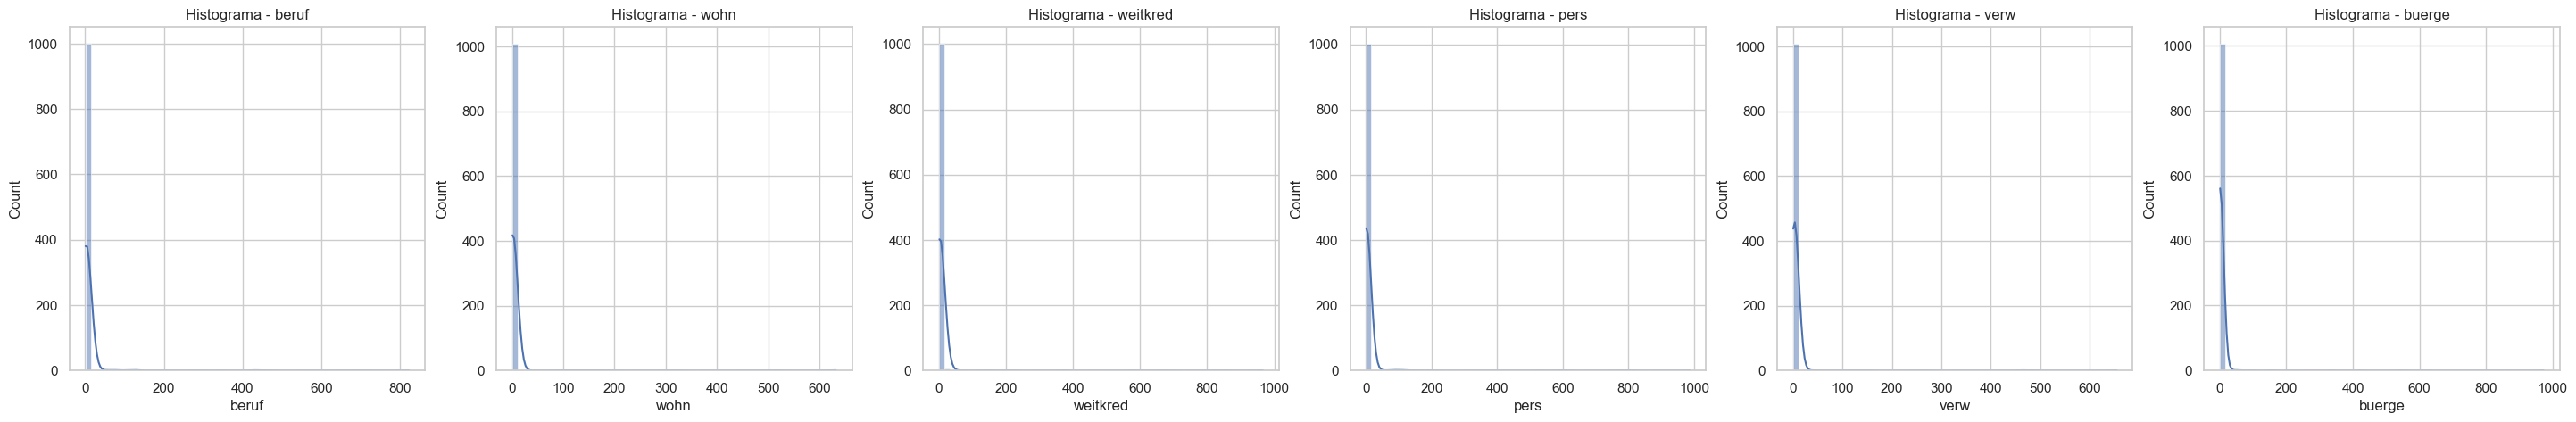

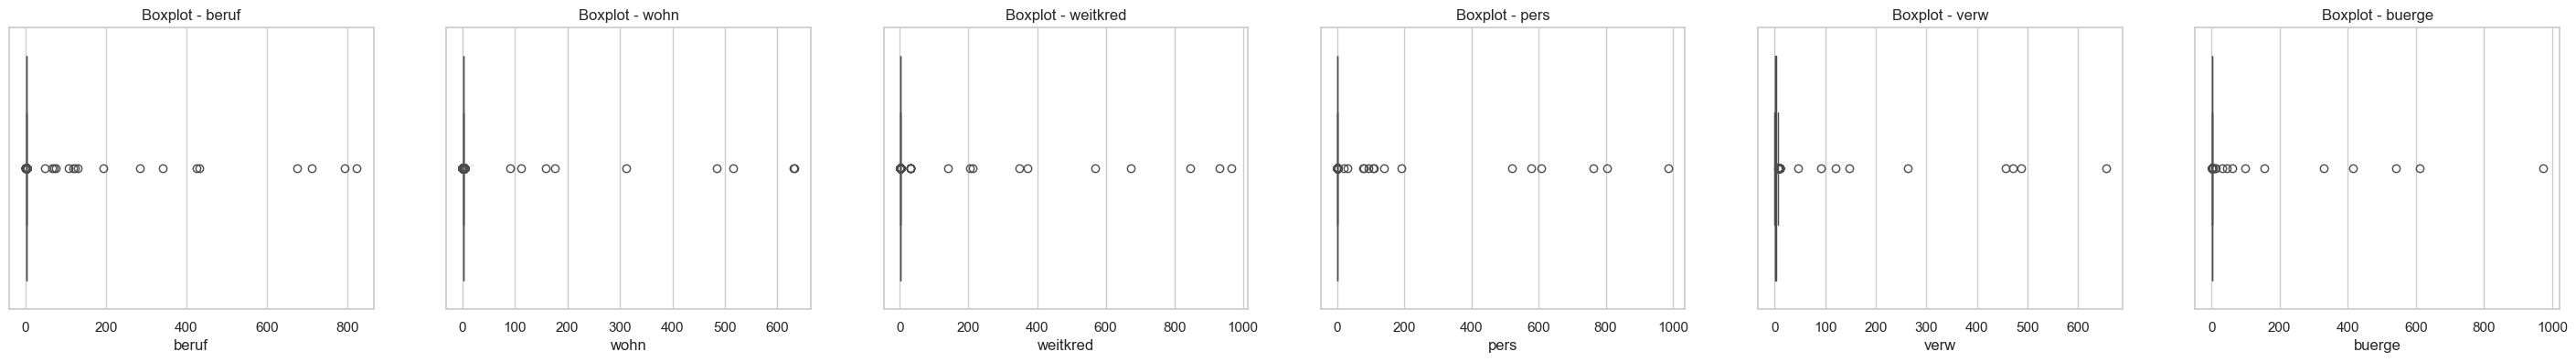

In [26]:
# Sección 7: Análisis de distribuciones y detección de outliers (IQR)
import math

def detect_and_cap_outliers(df, k=1.5, apply_cap=True, top_n_plots=6):
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    report = []
    df_capped = df.copy()
    for col in num_cols:
        s = pd.to_numeric(df[col], errors='coerce').astype(float)
        q1 = s.quantile(0.25)
        q3 = s.quantile(0.75)
        iqr = q3 - q1
        lower = q1 - k * iqr
        upper = q3 + k * iqr
        out_mask = (s < lower) | (s > upper)
        n_out = int(out_mask.sum())
        pct_out = 100 * n_out / max(1, len(s.dropna()))
        # determinar límites no-outlier
        non_out = s[~out_mask].dropna()
        cap_low = non_out.min() if not non_out.empty else lower
        cap_high = non_out.max() if not non_out.empty else upper
        report.append({'column': col, 'n_outliers': n_out, 'pct_outliers': pct_out, 'lower': float(lower) if not math.isnan(lower) else None, 'upper': float(upper) if not math.isnan(upper) else None, 'cap_low': float(cap_low) if not pd.isna(cap_low) else None, 'cap_high': float(cap_high) if not pd.isna(cap_high) else None})
        # aplicar capping si se solicita
        if apply_cap and n_out > 0:
            capped = s.copy()
            capped[s < lower] = cap_low
            capped[s > upper] = cap_high
            # intentar mantener dtype nullable si era Int64
            try:
                df_capped[col] = pd.Series(pd.to_numeric(capped, errors='coerce')).round(0).astype('Int64')
            except Exception:
                df_capped[col] = capped
            # registrar en cleaning_rules
            cleaning_rules.setdefault(col, []).append({'outlier_detection': {'method': 'IQR', 'k': k, 'n_outliers': n_out, 'pct_outliers': pct_out, 'cap_low': cap_low, 'cap_high': cap_high}})
        else:
            cleaning_rules.setdefault(col, []).append({'outlier_detection': {'method': 'IQR', 'k': k, 'n_outliers': n_out, 'pct_outliers': pct_out}})
    report_df = pd.DataFrame(report).sort_values('pct_outliers', ascending=False).reset_index(drop=True)
    return report_df, df_capped

# Ejecutar detección y aplicar capping (apply_cap=True)
outlier_report, df_capped = detect_and_cap_outliers(df, k=1.5, apply_cap=True, top_n_plots=6)
print('Reporte de outliers (ordenado por % outliers):')
display(outlier_report.head(30))

# Graficar distribuciones de las columnas con más outliers
top_cols = outlier_report.loc[outlier_report['n_outliers'] > 0, 'column'].head(6).tolist()
if top_cols:
    import matplotlib.gridspec as gridspec
    n = len(top_cols)
    fig = plt.figure(figsize=(6 * n, 5))
    for i, c in enumerate(top_cols, 1):
        ax1 = fig.add_subplot(1, n, i)
        sns.histplot(pd.to_numeric(df[c], errors='coerce').dropna(), kde=True, ax=ax1)
        ax1.set_title(f'Histograma - {c}')
    plt.show()
    # boxplots
    fig2 = plt.figure(figsize=(6 * n, 4))
    for i, c in enumerate(top_cols, 1):
        ax = fig2.add_subplot(1, n, i)
        sns.boxplot(x=pd.to_numeric(df[c], errors='coerce').dropna(), ax=ax)
        ax.set_title(f'Boxplot - {c}')
    plt.show()
else:
    print('No hay columnas con outliers detectados por IQR')

# Guardar reglas actualizadas
# Guardar reglas actualizadas
#with open(rules_path, 'w', encoding='utf-8') as f:
#    import json
#    json.dump(cleaning_rules, f, ensure_ascii=False, indent=2)
#print('Reglas con información de outliers guardadas en', rules_path)


In [27]:
#Volvemos a verificar duplicados ahora que eliminamos outliers
df = df_capped.drop_duplicates()
print(df.shape)

(1009, 21)


In [28]:
# Revisamos distribución de los datos limpios
df.describe()

,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,wohnzeit,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit
count,1009.0,1009.0,1009.0,1009.0,1009.0,1009.0,1009.0,1009.0,1009.0,1009.0,1009.0,1009.0,1009.0,1009.0,1009.0,1009.0,1009.0,1009.0,1009.0,1009.0,1009.0
mean,2.612488,20.548067,2.569871,2.534192,3063.353816,2.127849,3.386521,2.983152,2.68781,1.0,2.850347,2.369673,35.601586,3.0,2.0,1.432111,3.0,2.0,1.411298,2.0,0.697721
std,1.250985,10.755486,1.086225,2.019024,2191.42068,1.594418,1.202369,1.117463,0.714546,0.0,1.098521,1.052733,11.223639,0.0,0.0,0.587232,0.0,0.0,0.492313,0.0,0.459473
min,1.0,4.0,0.0,0.0,250.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,19.0,3.0,2.0,1.0,3.0,2.0,1.0,2.0,0.0
25%,1.0,12.0,2.0,1.0,1374.0,1.0,3.0,2.0,2.0,1.0,2.0,1.0,27.0,3.0,2.0,1.0,3.0,2.0,1.0,2.0,0.0
50%,2.0,18.0,2.0,2.0,2319.0,1.0,3.0,3.0,3.0,1.0,3.0,2.0,33.0,3.0,2.0,1.0,3.0,2.0,1.0,2.0,1.0
75%,4.0,24.0,4.0,3.0,3979.0,3.0,5.0,4.0,3.0,1.0,4.0,3.0,42.0,3.0,2.0,2.0,3.0,2.0,2.0,2.0,1.0
max,4.0,42.0,4.0,6.0,7882.0,5.0,5.0,4.0,4.0,1.0,4.0,4.0,64.0,3.0,2.0,3.0,3.0,2.0,2.0,2.0,1.0


In [29]:
# Contra distribución del dataset original
df_orig.describe()

,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,wohnzeit,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.577000,20.903000,2.54500,2.828000,3271.24800,2.105000,3.384000,2.973000,2.68200,1.145000,2.845000,2.358000,35.54200,2.675000,1.928000,1.407000,2.904000,1.845000,1.404000,1.963000,0.700000
std,1.257638,12.058814,1.08312,2.744439,2822.75176,1.580023,1.208306,1.118715,0.70808,0.477706,1.103718,1.050209,11.35267,0.705601,0.530186,0.577654,0.653614,0.362086,0.490943,0.188856,0.458487
min,1.000000,4.000000,0.00000,0.000000,250.00000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,19.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,1.000000,12.000000,2.00000,1.000000,1365.50000,1.000000,3.000000,2.000000,2.00000,1.000000,2.000000,1.000000,27.00000,3.000000,2.000000,1.000000,3.000000,2.000000,1.000000,2.000000,0.000000
50%,2.000000,18.000000,2.00000,2.000000,2319.50000,1.000000,3.000000,3.000000,3.00000,1.000000,3.000000,2.000000,33.00000,3.000000,2.000000,1.000000,3.000000,2.000000,1.000000,2.000000,1.000000
75%,4.000000,24.000000,4.00000,3.000000,3972.25000,3.000000,5.000000,4.000000,3.00000,1.000000,4.000000,3.000000,42.00000,3.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,1.000000
max,4.000000,72.000000,4.00000,10.000000,18424.00000,5.000000,5.000000,4.000000,4.00000,3.000000,4.000000,4.000000,75.00000,3.000000,3.000000,4.000000,4.000000,2.000000,2.000000,2.000000,1.000000


## Sección 8: Correlaciones, multicolinealidad y redundancia
Detectamos correlaciones (Pearson y Spearman) entre variables numéricas y calculamos VIF para evaluar multicolinealidad.

🔢 Columnas numéricas para correlación y VIF: ['laufkont', 'laufzeit', 'moral', 'verw', 'hoehe', 'sparkont', 'beszeit', 'rate', 'famges', 'buerge', 'wohnzeit', 'verm', 'alter', 'weitkred', 'wohn', 'bishkred', 'beruf', 'pers', 'telef', 'gastarb', 'kredit']


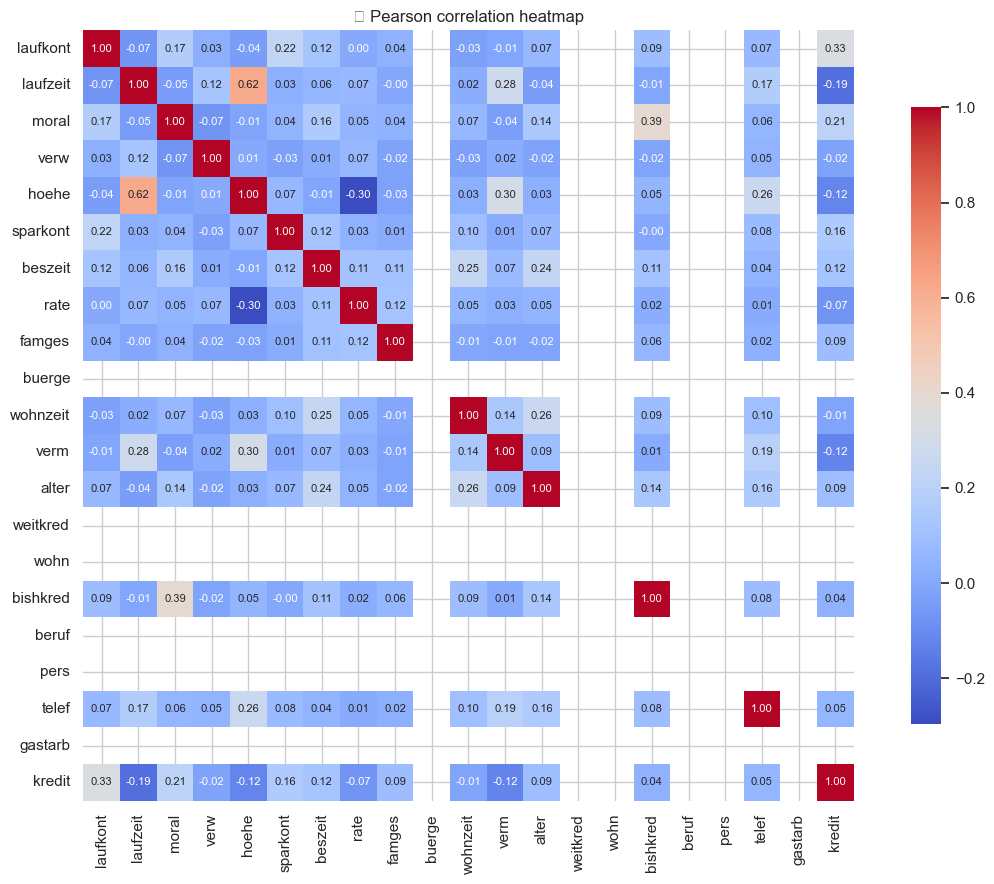

📊 VIF (Factor de inflación de la varianza):


,Variable,VIF
0,weitkred,inf
1,gastarb,inf
2,pers,inf
3,beruf,inf
4,buerge,inf
5,wohn,inf
6,hoehe,2.23
7,laufzeit,1.95
8,rate,1.31
9,moral,1.28


In [37]:
# Sección 8: Correlaciones y VIF (con texto más pequeño)

# Columnas numéricas
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print('🔢 Columnas numéricas para correlación y VIF:', num_cols)

if num_cols:
    # Pearson y Spearman
    pearson = df[num_cols].corr(method='pearson')
    spearman = df[num_cols].corr(method='spearman')

    # Heatmap Pearson con valores anotados más pequeños
    try:
        plt.figure(figsize=(12, 9))
        sns.heatmap(
            pearson,
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            square=True,
            annot_kws={"size": 8},   # 👈 Ajuste de tamaño de fuente
            cbar_kws={'shrink': .8}
        )
        plt.title('🔷 Pearson correlation heatmap')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print('❌ No se pudo graficar el heatmap:', e)

    # Cálculo de VIF (rellenamos NaN con mediana)
    from sklearn.linear_model import LinearRegression

    X = df[num_cols].copy().fillna(df[num_cols].median())
    vifs = []
    for i, col in enumerate(num_cols):
        try:
            y = X[col].values
            X_other = X.drop(columns=[col]).values
            lr = LinearRegression()
            lr.fit(X_other, y)
            r2 = lr.score(X_other, y)
            vif = 1.0 / (1.0 - r2) if r2 < 0.9999 else float('inf')
        except Exception as e:
            vif = None
        vifs.append({'Variable': col, 'VIF': vif})

    vif_df = pd.DataFrame(vifs).sort_values('VIF', ascending=False).reset_index(drop=True)

    # Mostrar tabla VIF con 2 decimales
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    print('📊 VIF (Factor de inflación de la varianza):')
    display(vif_df)
else:
    print('⚠️ No hay columnas numéricas para analizar.')


In [31]:
df.groupby('kredit').count()

,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,wohnzeit,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb
kredit,,,,,,,,,,,,,,,,,,,,
0,305,305,305,305,305,305,305,305,305,305,305,305,305,305,305,305,305,305,305,305
1,704,704,704,704,704,704,704,704,704,704,704,704,704,704,704,704,704,704,704,704


## Sección 8.1: Correlaciones, multicolinealidad y redundancia Comparación Data Set orginal vs Data set clean


📸 Comparando datos modificados (df2) vs datos limpios (df_clean)...


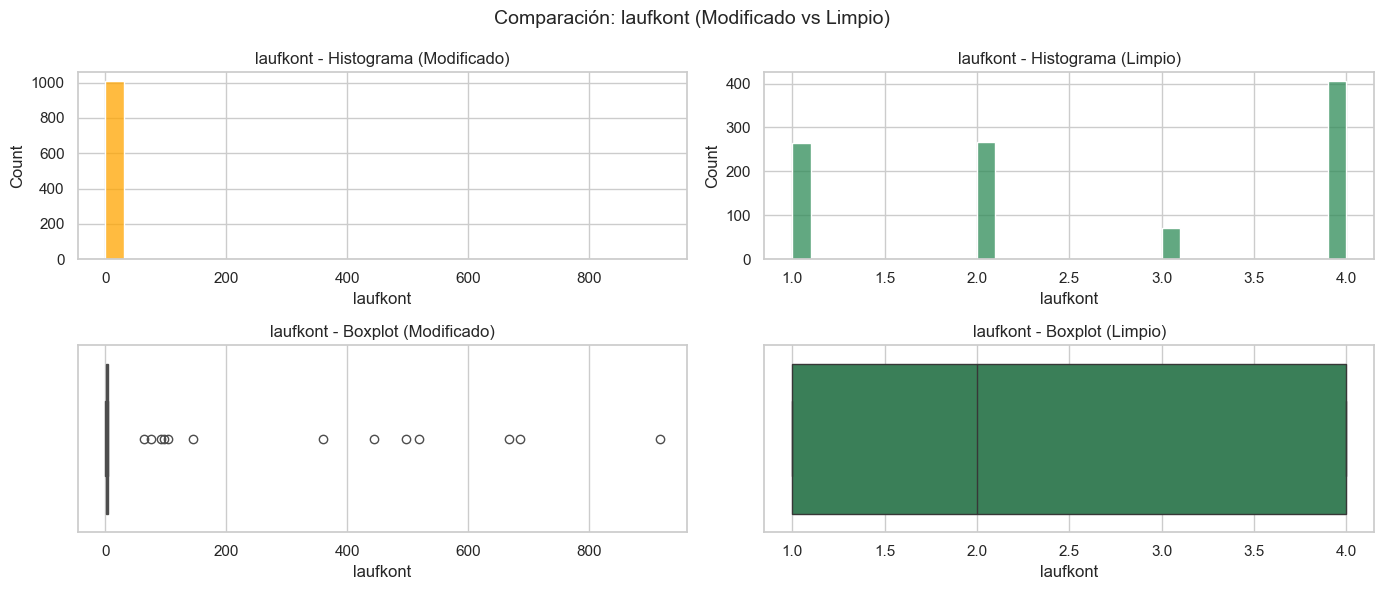

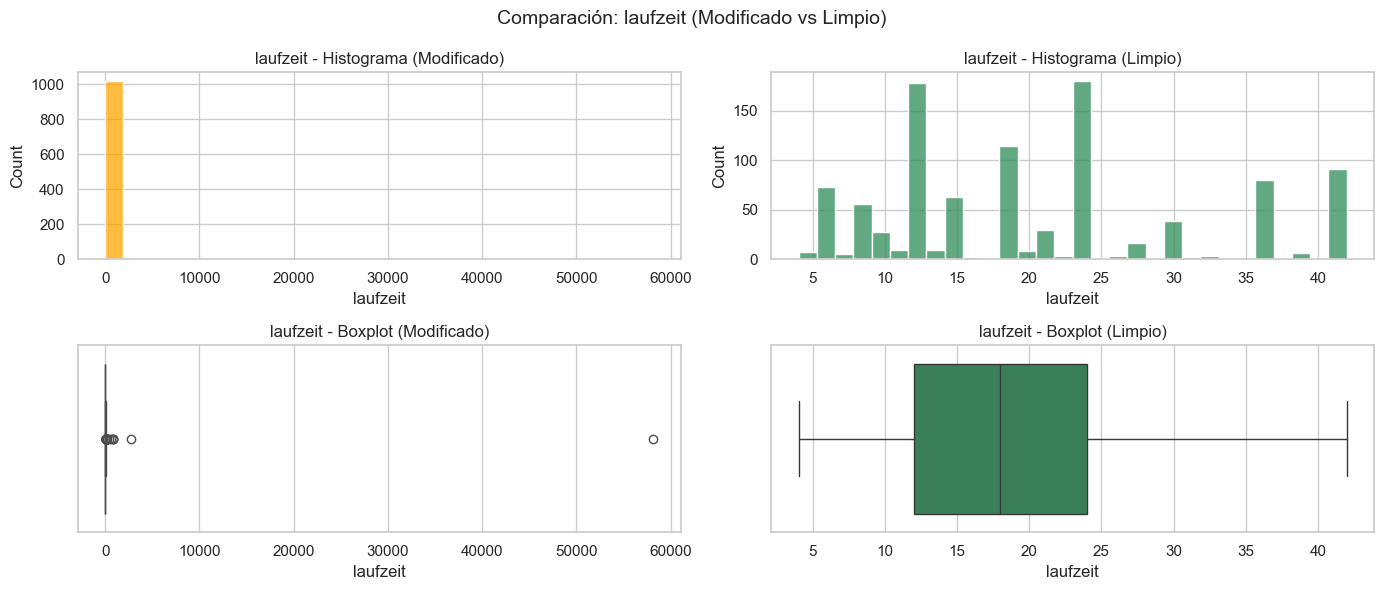

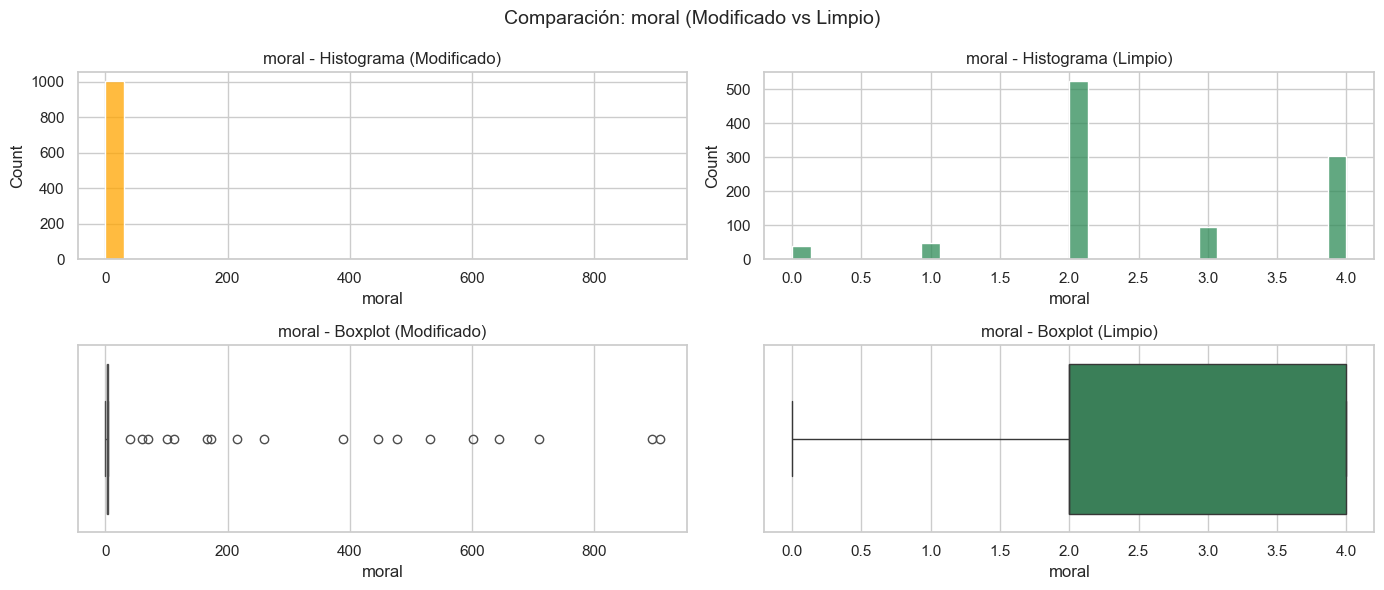

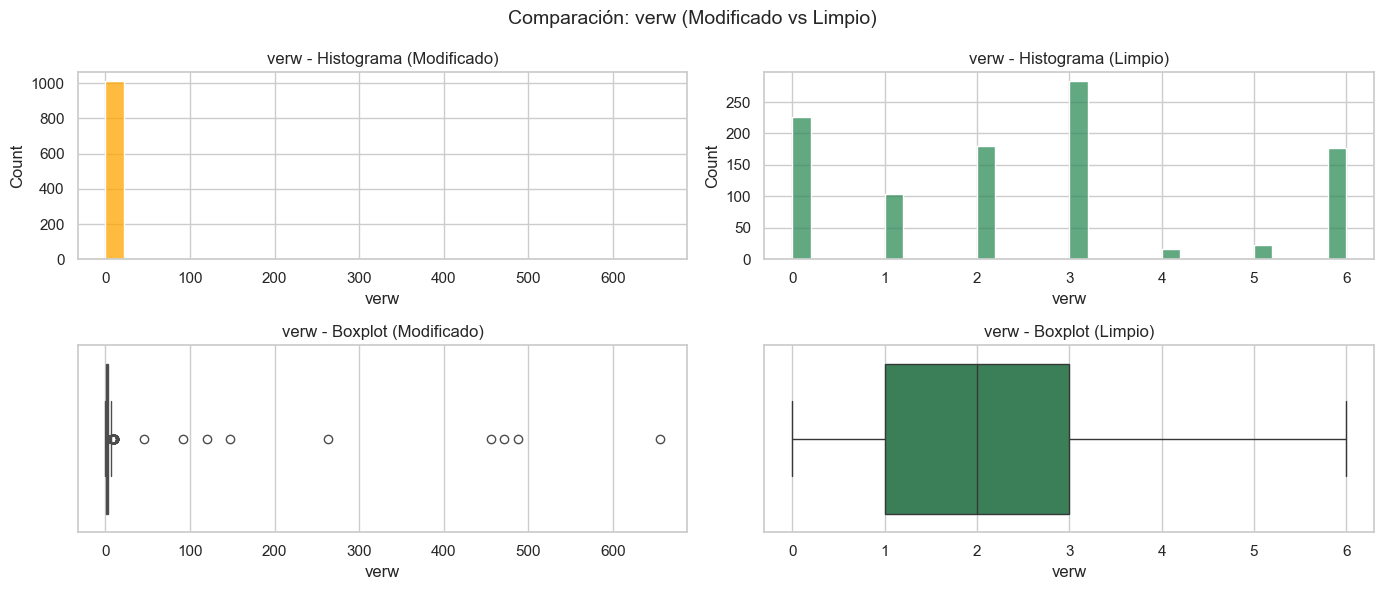

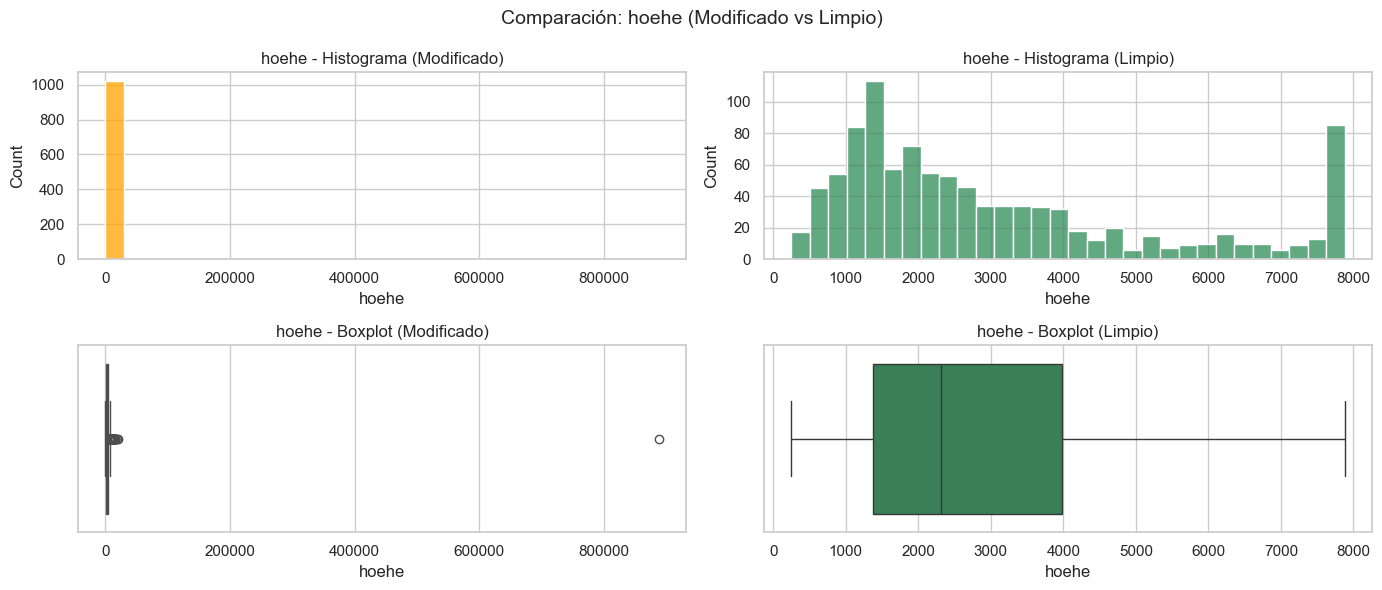

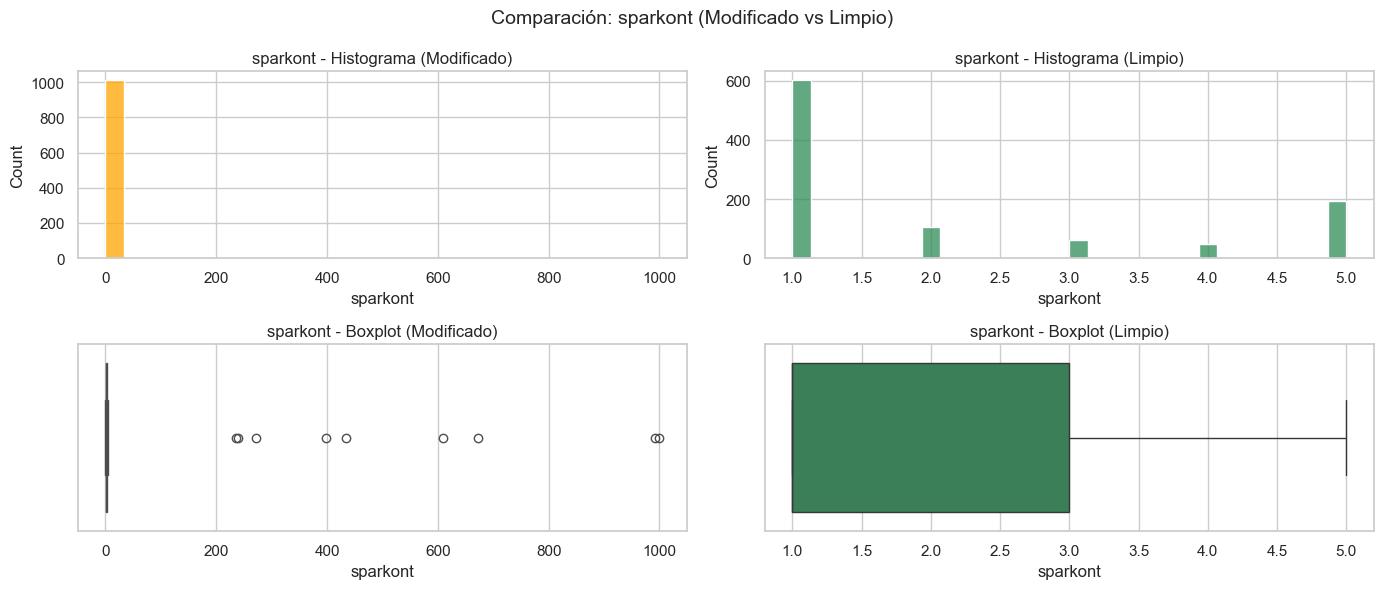

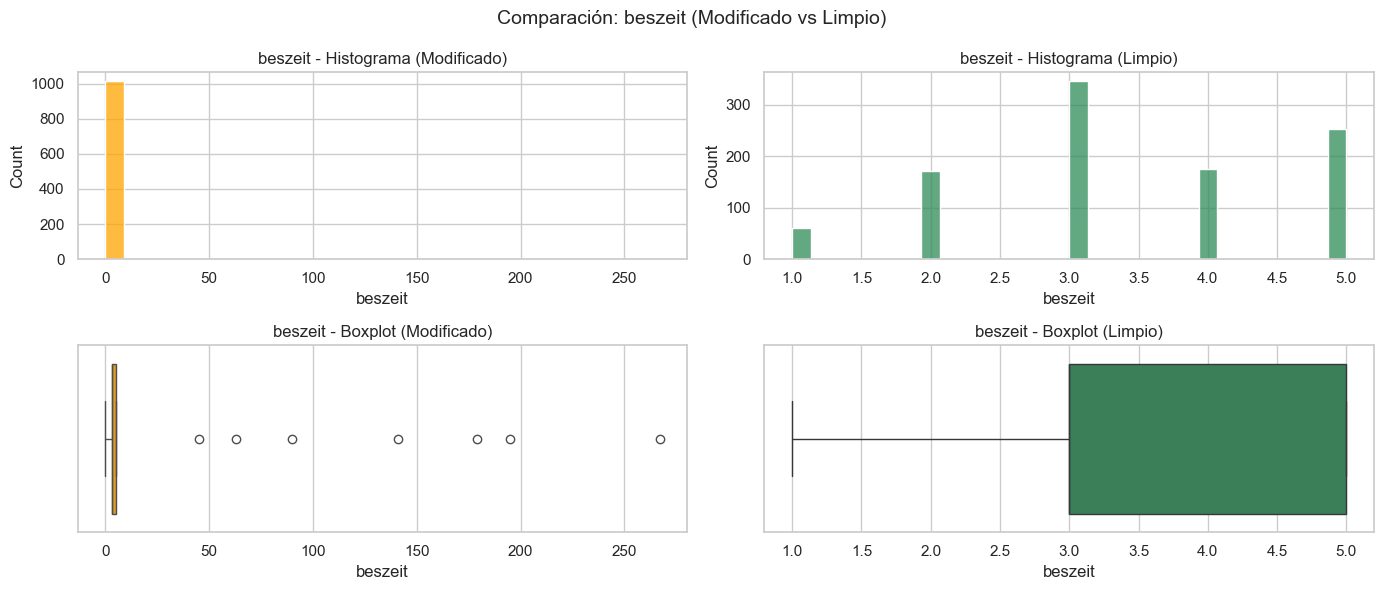

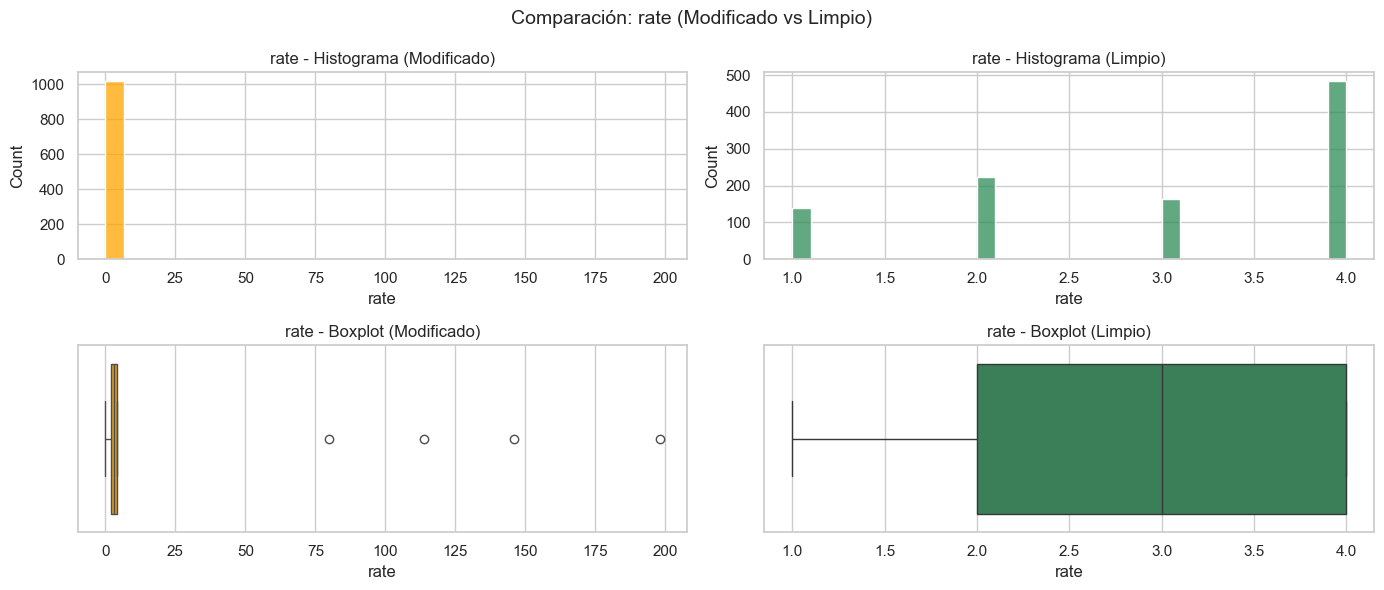

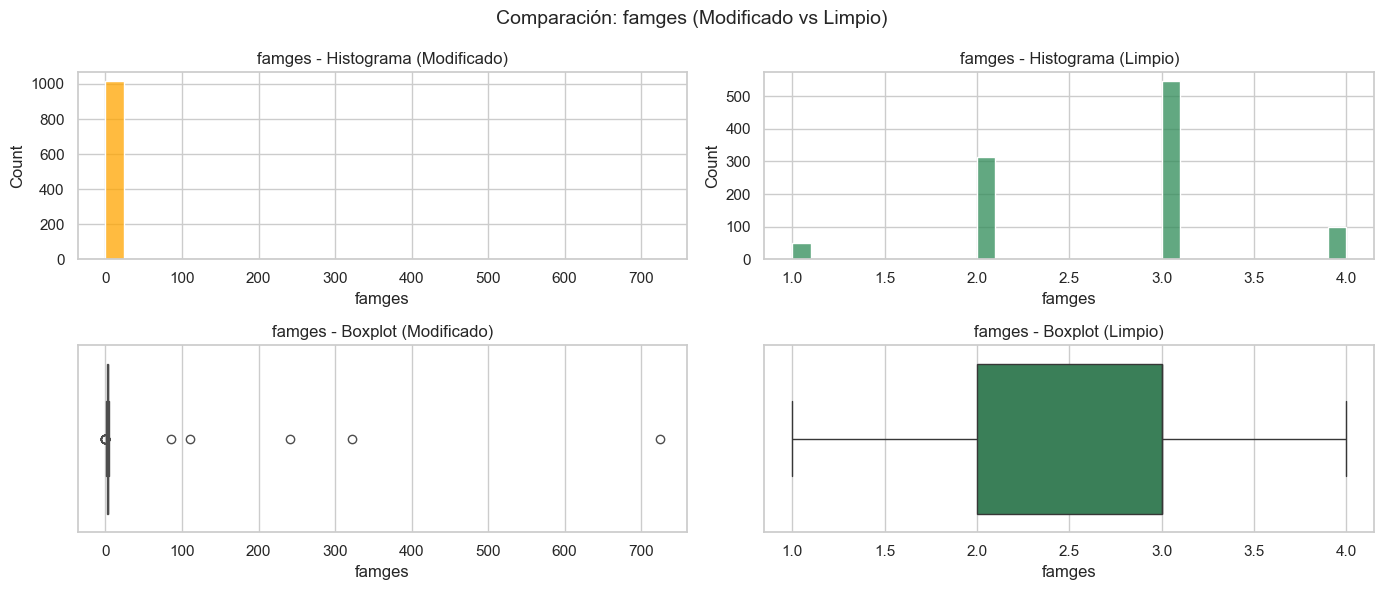

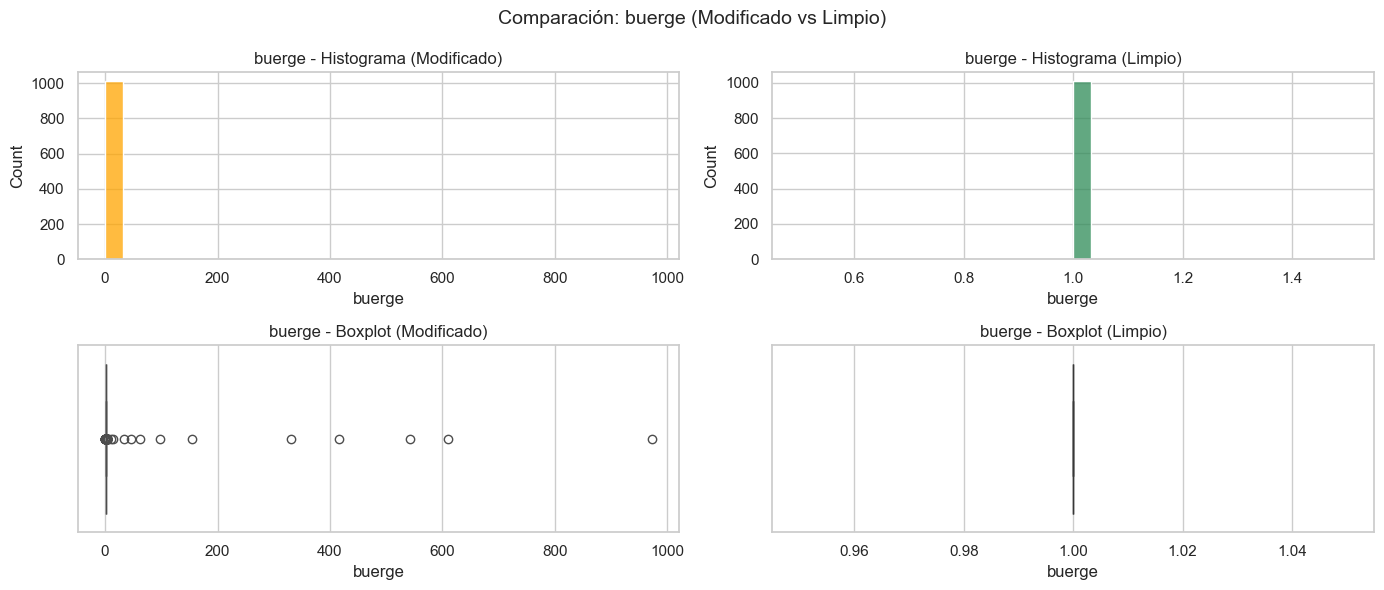

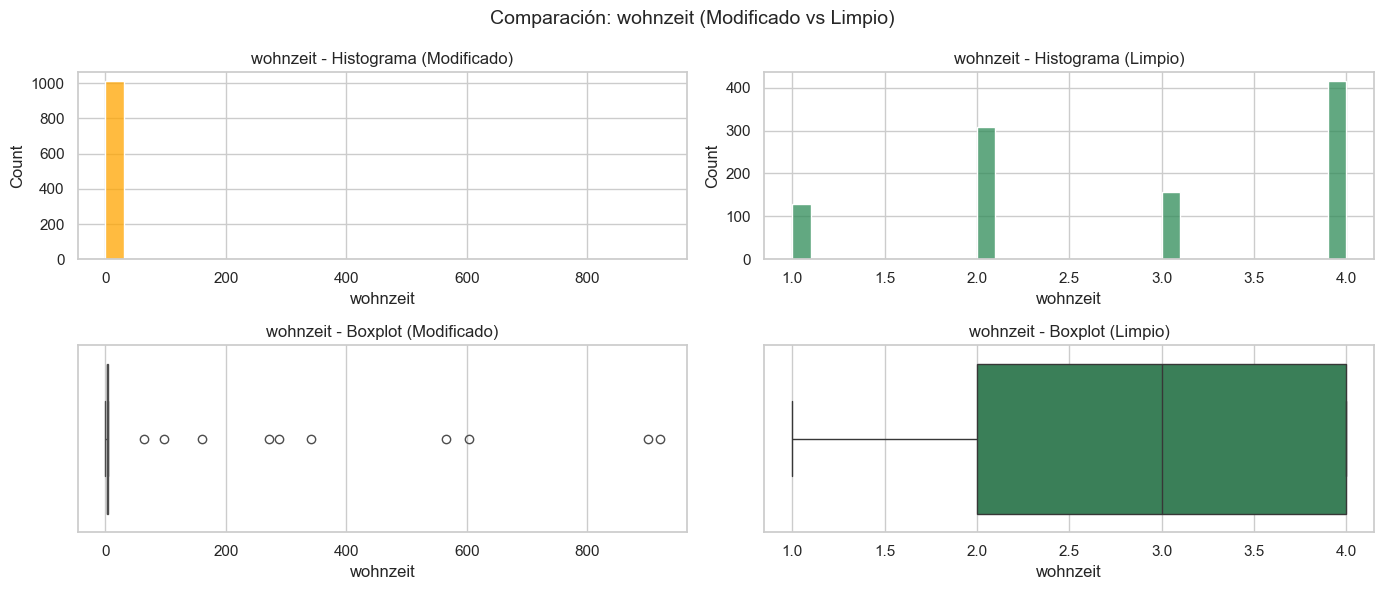

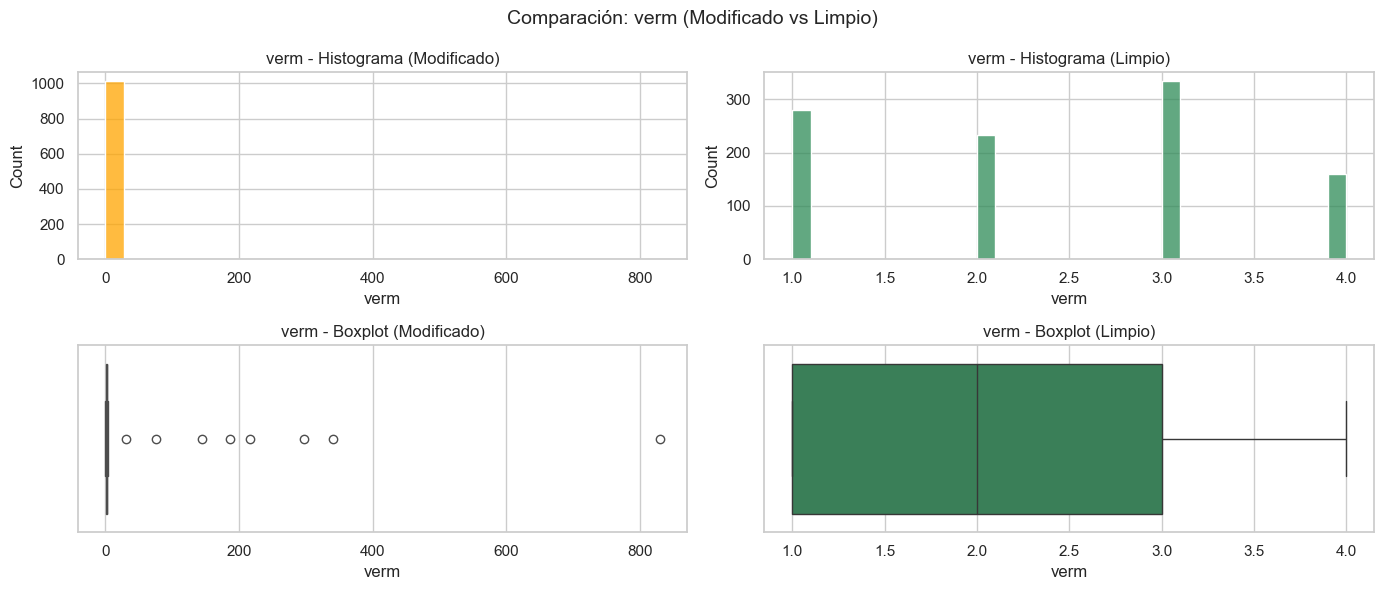

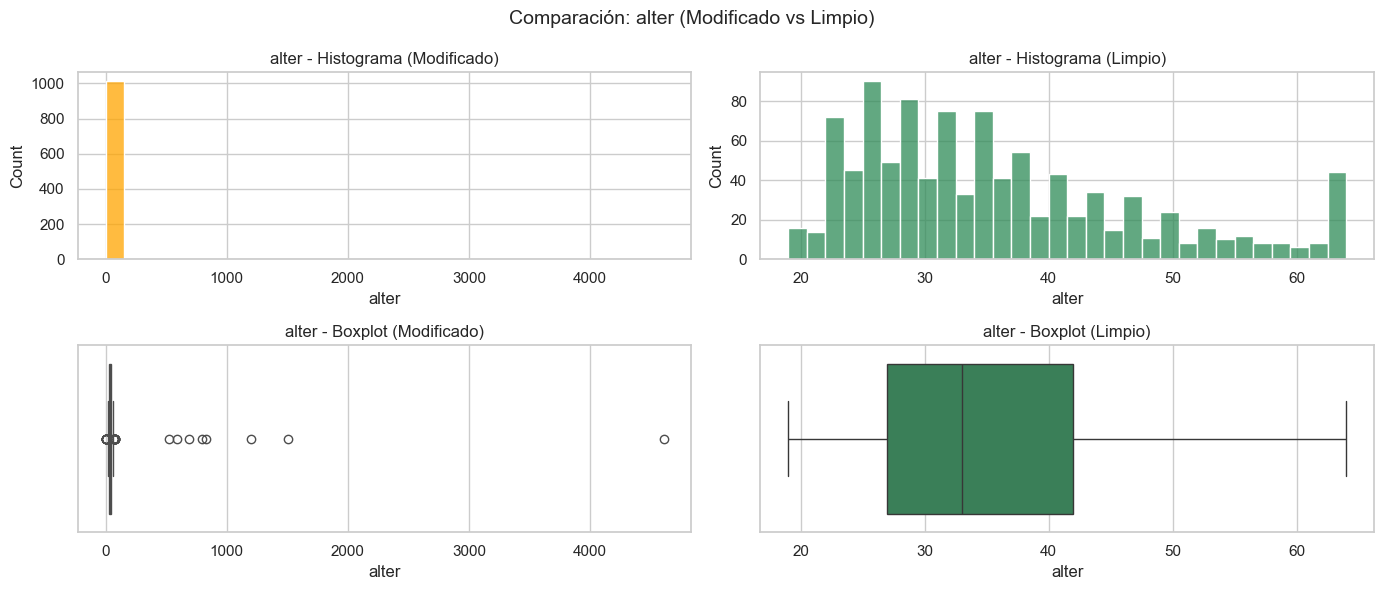

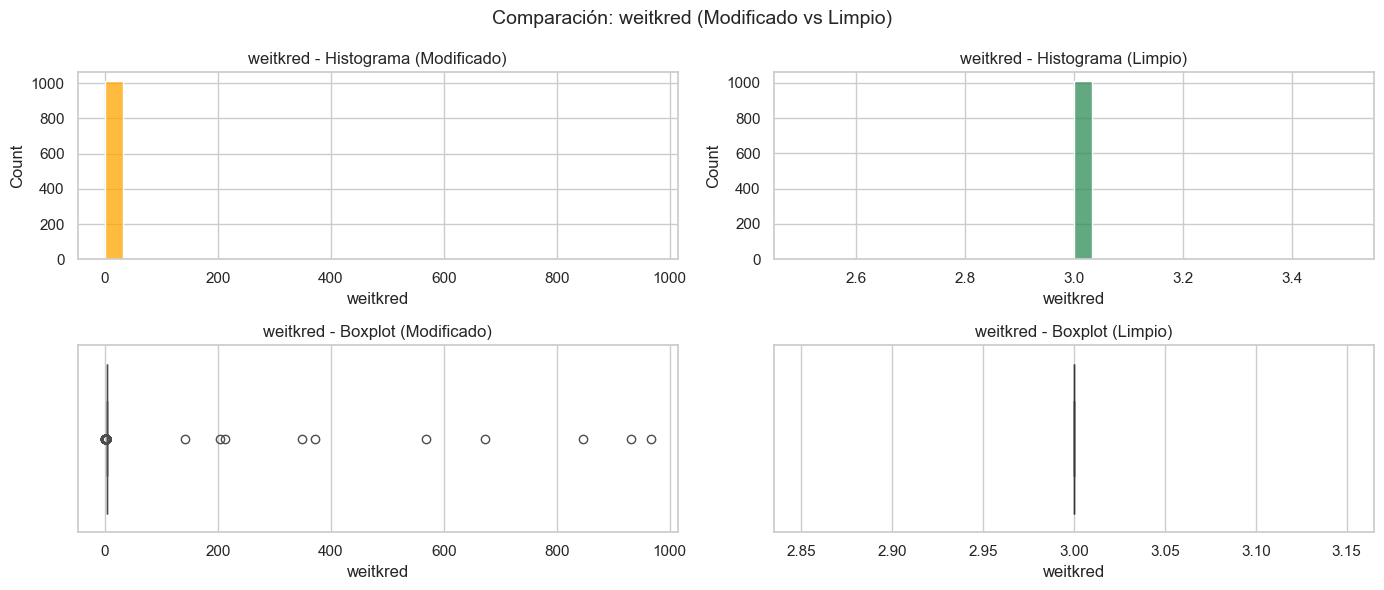

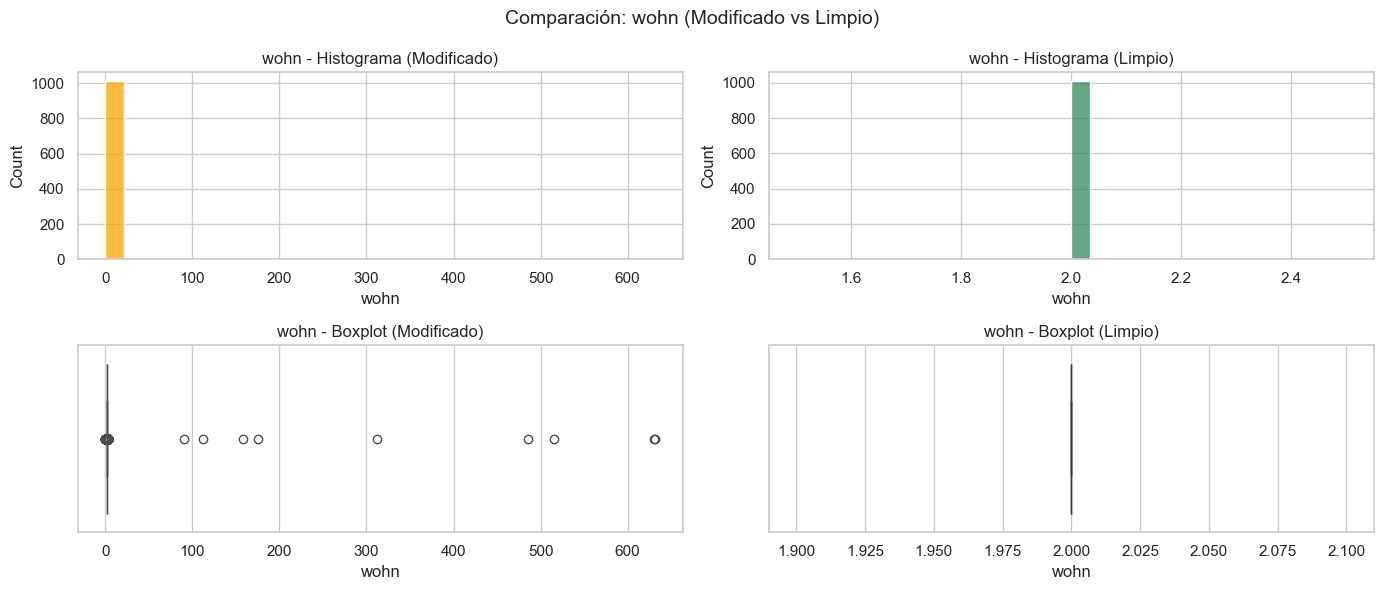

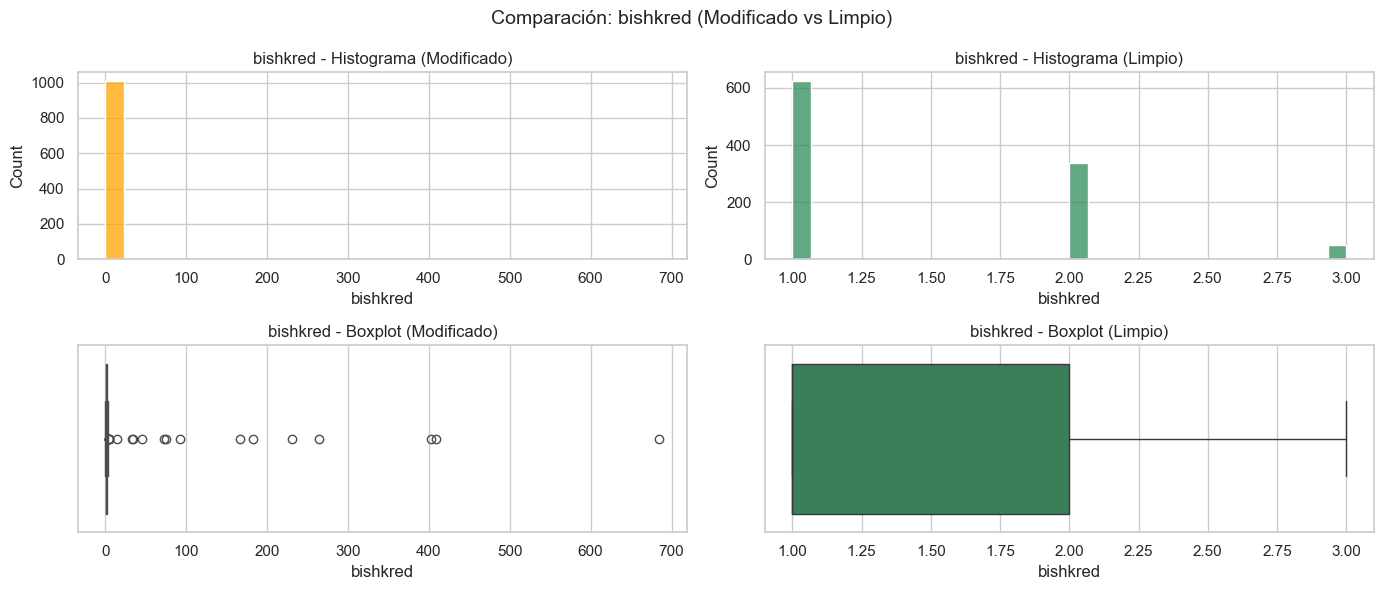

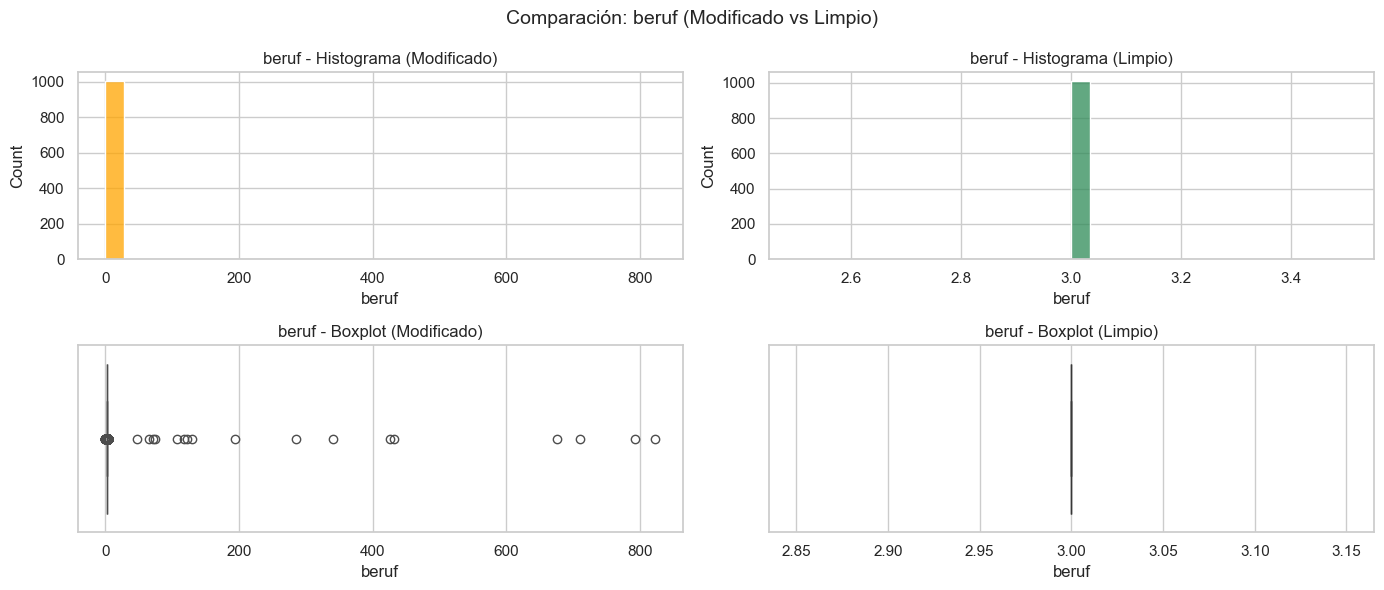

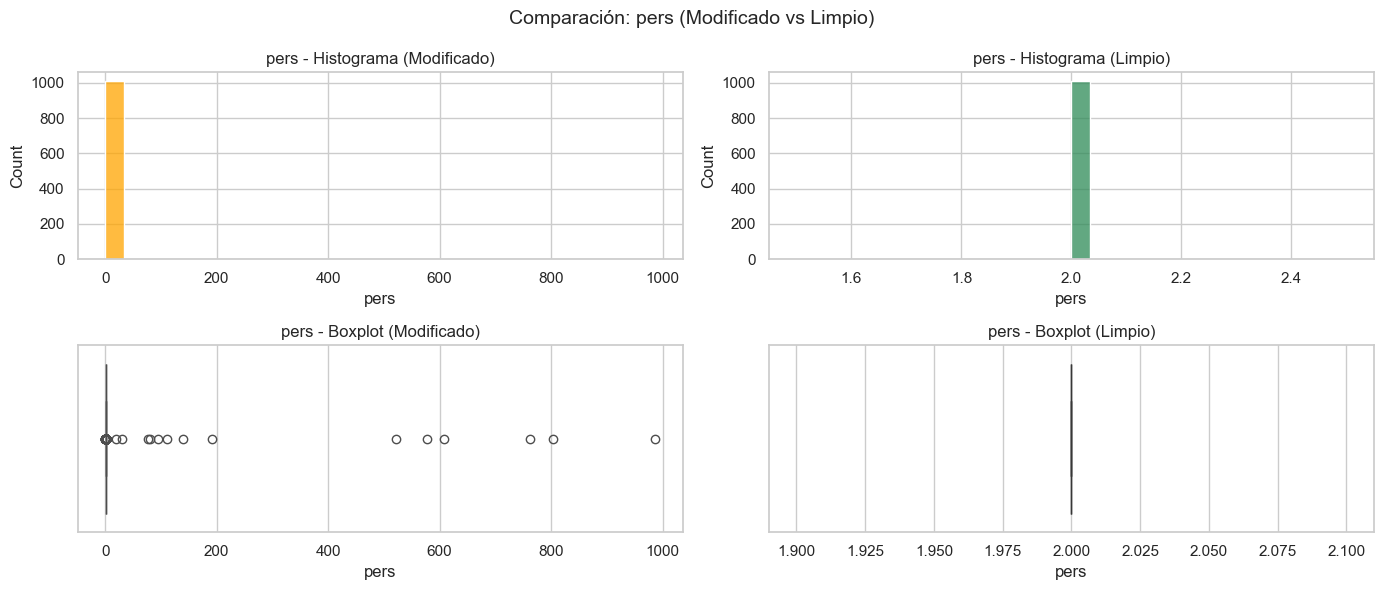

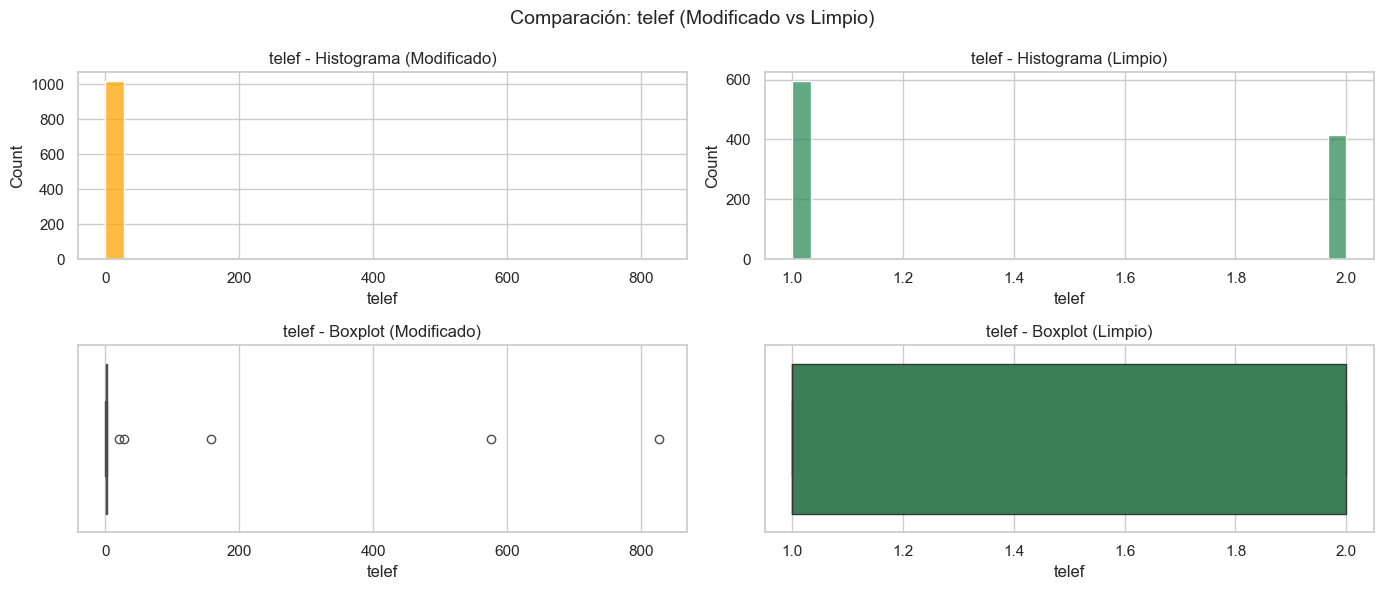

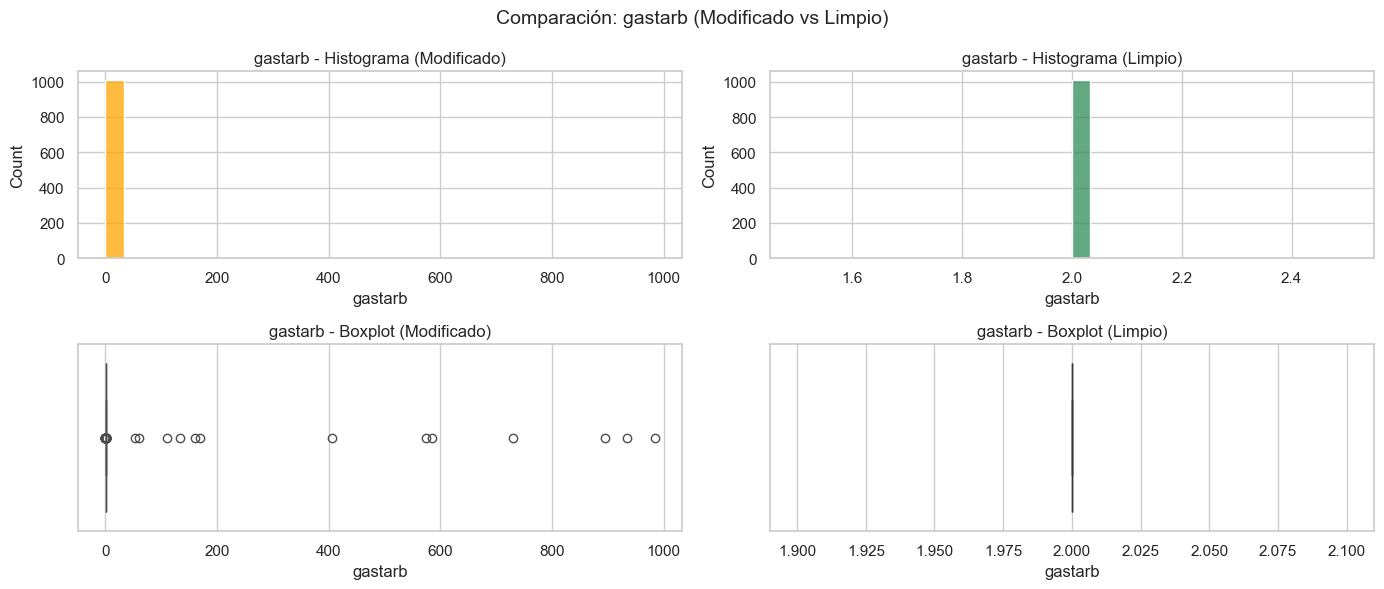

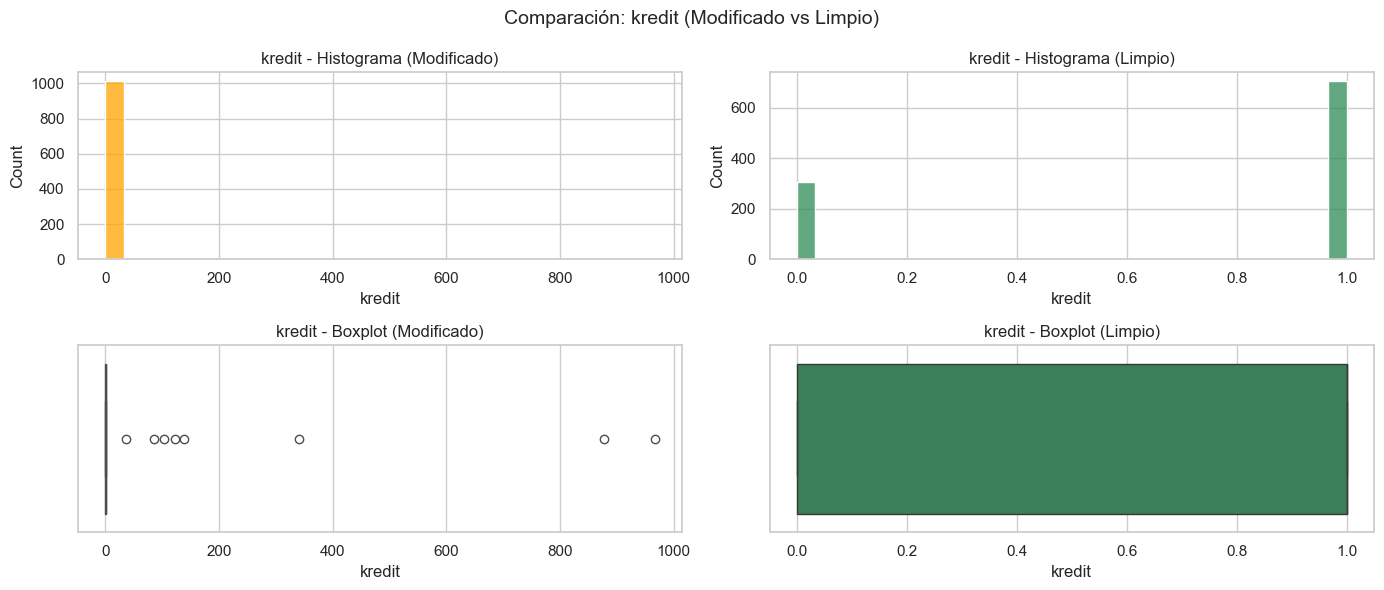

In [35]:
# =============================
# 📊 COMPARACIÓN VISUAL: MODIFICADO VS LIMPIO
# =============================

print("\n📸 Comparando datos modificados (df2) vs datos limpios (df_clean)...")

for col in num_cols:
    if col not in df.columns:
        continue  # por seguridad

    modificado = df2[col].astype(float)
    limpio = df[col].astype(float)

    plt.figure(figsize=(14, 6))

    # Histograma modificado
    plt.subplot(2, 2, 1)
    sns.histplot(modificado, bins=30, color='orange')
    plt.title(f"{col} - Histograma (Modificado)")

    # Histograma limpio
    plt.subplot(2, 2, 2)
    sns.histplot(limpio, bins=30, color='seagreen')
    plt.title(f"{col} - Histograma (Limpio)")

    # Boxplot modificado
    plt.subplot(2, 2, 3)
    sns.boxplot(x=modificado, color='orange')
    plt.title(f"{col} - Boxplot (Modificado)")

    # Boxplot limpio
    plt.subplot(2, 2, 4)
    sns.boxplot(x=limpio, color='seagreen')
    plt.title(f"{col} - Boxplot (Limpio)")

    plt.suptitle(f"Comparación: {col} (Modificado vs Limpio)", fontsize=14)
    plt.tight_layout()
    plt.show()

In [32]:
#   Guardamos el dataset limpio
df.to_csv(OUT_PATH_CLEAN)